In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-surprise
# %pip install joblib

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
import os

In [3]:
# Function to read a single data file and return a DataFrame
def read_data_file(file_path):
    data_list = []
    with open(file_path, 'r') as file:
        current_movie_id = None
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                current_movie_id = int(line.replace(':', ''))
            else:
                customer_id, rating, date = line.split(',')
                data_list.append([int(customer_id), current_movie_id, float(rating), date])
    return pd.DataFrame(data_list, columns=['Cust_Id', 'Movie_Id', 'Rating', 'Date'])

In [4]:
# Function to filter out inactive users based on the specified quantile threshold
def filter_active_users(ratings, quantile_threshold=0.7):
    ratings_count = ratings['Cust_Id'].value_counts()
    active_users = ratings_count[ratings_count >= ratings_count.quantile(quantile_threshold)].index
    return ratings[ratings['Cust_Id'].isin(active_users)]

In [5]:
# Function to prepare data for the Surprise library
def prepare_data_for_surprise(ratings):
    reader = Reader(rating_scale=(1, 5))
    return Dataset.load_from_df(ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)

In [6]:
# List of combined data files
data_files = [
    'combined_data_1.txt',
    'combined_data_2.txt',
    'combined_data_3.txt',
    'combined_data_4.txt'
]

# Load data from the first file for training
train_ratings_1 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[0]))

# Load data from the second file for training
train_ratings_2 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[1]))

# Concatenate training data
train_ratings = pd.concat([train_ratings_1, train_ratings_2])

print(train_ratings.head())


   Cust_Id  Movie_Id  Rating        Date
0  1488844         1     3.0  2005-09-06
1   822109         1     5.0  2005-05-13
2   885013         1     4.0  2005-10-19
3    30878         1     4.0  2005-12-26
4   823519         1     3.0  2004-05-03


In [7]:
del train_ratings_1
del train_ratings_2

In [8]:
# Filter inactive users from training data
train_ratings = filter_active_users(train_ratings)
print(train_ratings.shape)


(39042100, 4)


In [9]:
# Basic statistics for training data
print(train_ratings.describe())


            Cust_Id      Movie_Id        Rating
count  3.904210e+07  3.904210e+07  3.904210e+07
mean   1.321310e+06  4.662919e+03  3.565960e+00
std    7.645209e+05  2.596012e+03  1.073088e+00
min    6.000000e+00  1.000000e+00  1.000000e+00
25%    6.604350e+05  2.443000e+03  3.000000e+00
50%    1.316977e+06  4.736000e+03  4.000000e+00
75%    1.983132e+06  6.844000e+03  4.000000e+00
max    2.649429e+06  9.210000e+03  5.000000e+00


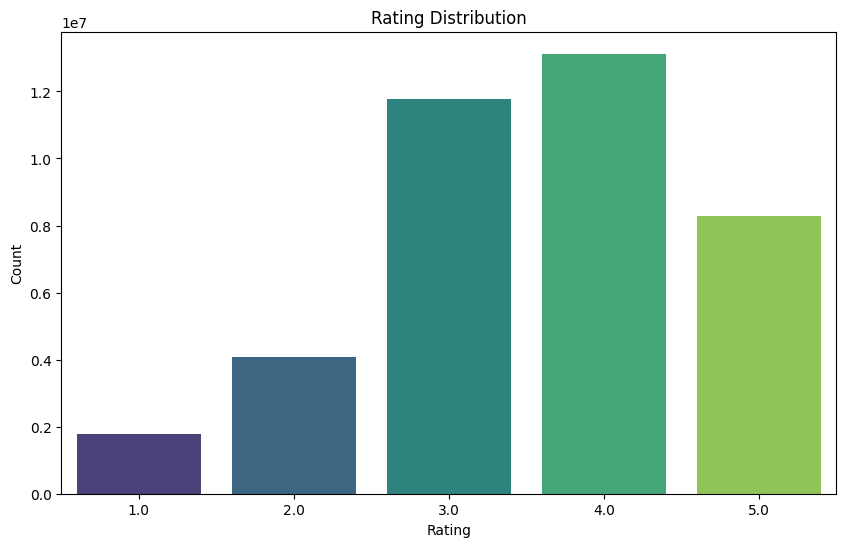

In [10]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_ratings, x='Rating', palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


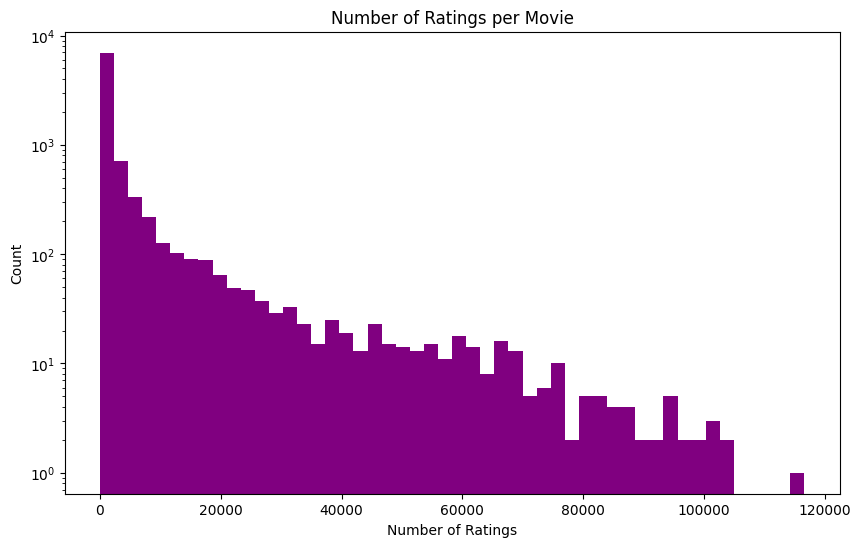

In [11]:
# Number of ratings per movie
ratings_per_movie = train_ratings.groupby('Movie_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, color='purple')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


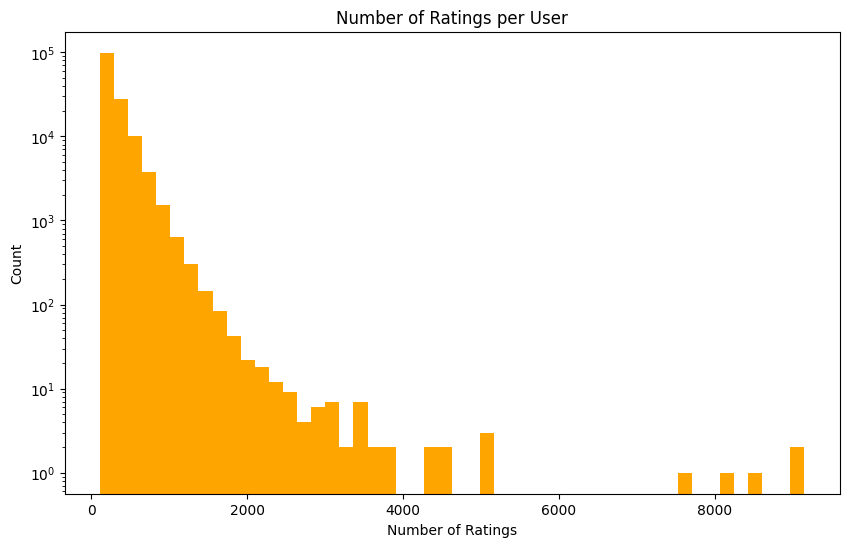

In [12]:
# Number of ratings per user
ratings_per_user = train_ratings.groupby('Cust_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='orange')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


In [13]:
# Prepare training data for the Surprise library
train_data = prepare_data_for_surprise(train_ratings)

In [ ]:
del train_ratings

In [ ]:
# Split the training data into train and validation sets
trainset, valset = train_test_split(train_data, test_size=0.25)


In [ ]:
del train_data

In [ ]:
# Define the SVD model
algo = SVD(n_epochs=20)

In [16]:
# Train the SVD model
algo.fit(trainset)


In [ ]:
# Evaluate the model on the validation set
val_predictions = algo.test(valset)
val_rmse = accuracy.rmse(val_predictions)
val_mae = accuracy.mae(val_predictions)
print(f'Validation RMSE: {val_rmse}, Validation MAE: {val_mae}')


In [18]:
# Clear unnecessary data structures to free up memory
del trainset
del valset
del val_predictions

import gc
gc.collect()

0

In [19]:
# Save the trained model to a file
model_filename = 'svd_model.joblib'
joblib.dump(algo, model_filename)
print(f"Model saved to {model_filename}")

Model saved to svd_model.joblib


In [20]:
# Load the saved model
algo = joblib.load(model_filename)
print("Model loaded successfully")

Model loaded successfully


In [21]:
# Load additional data files
train_ratings_3 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[2]))
train_ratings_4 = read_data_file(os.path.join('/kaggle/input/netflix-prize-data/', data_files[3]))

In [22]:
# Concatenate the additional data with the existing training data
additional_ratings = pd.concat([train_ratings_3, train_ratings_4])

In [23]:
del train_ratings_3
del train_ratings_4

In [24]:
# Filter inactive users from additional training data
additional_ratings = filter_active_users(additional_ratings)
print(additional_ratings.shape)

(37379218, 4)


In [ ]:
# Basic statistics for additional data
print(additional_ratings.describe())

In [ ]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=additional_ratings, x='Rating', palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# Number of ratings per movie
ratings_per_movie = additional_ratings.groupby('Movie_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, color='purple')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [ ]:
# Number of ratings per user
ratings_per_user = additional_ratings.groupby('Cust_Id').size()
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='orange')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [25]:
# Prepare additional data for the Surprise library
additional_data = prepare_data_for_surprise(additional_ratings)

In [ ]:
del additional_ratings

In [ ]:
# Split the additional data into train and validation sets
additional_trainset, additional_valset = train_test_split(additional_data, test_size=0.25)

In [ ]:
del additional_data

In [27]:
# Train the model incrementally with additional data
algo.fit(additional_trainset)

In [28]:
# Evaluate the model on the additional validation set
additional_val_predictions = algo.test(additional_valset)
additional_val_rmse = accuracy.rmse(additional_val_predictions)
additional_val_mae = accuracy.mae(additional_val_predictions)
print(f'Additional Validation RMSE: {additional_val_rmse}, Additional Validation MAE: {additional_val_mae}')

RMSE: 0.8235
MAE:  0.6378
Additional Validation RMSE: 0.8234955822689443, Additional Validation MAE: 0.6378340449017716


In [29]:
# Clear unnecessary data structures to free up memory
del additional_trainset
del additional_valset

import gc
gc.collect()

0

In [ ]:
# Save the updated model
updated_model_filename = 'svd_model_updated.joblib'
joblib.dump(algo, updated_model_filename)
print(f"Updated model saved to {updated_model_filename}")

In [ ]:
# Example prediction for a specific user and movie
user_id = '712664'  # replace with a valid user ID from your dataset
movie_id = '3'      # replace with a valid movie ID from your dataset
prediction = algo.predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} and movie {movie_id}: {prediction.est:.2f}")


In [ ]:
# Function to get top-N recommendations for a user
def get_top_n_recommendations(algo, user_id, ratings, n=10):
    # Get all movie IDs
    all_movie_ids = ratings['Movie_Id'].unique()
    
    # Get movie IDs the user has already rated
    rated_movie_ids = ratings[ratings['Cust_Id'] == int(user_id)]['Movie_Id']
    
    # Create a list of (movie_id, predicted_rating) for movies not yet rated by the user
    predictions = [algo.predict(user_id, str(movie_id)) for movie_id in all_movie_ids if movie_id not in rated_movie_ids]
    
    # Sort the predictions by estimated rating in descending order
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Extract the movie IDs from the top-N predictions
    top_n_movie_ids = [pred.iid for pred in top_n_predictions]
    
    return top_n_movie_ids



In [ ]:
# Get top 10 recommendations for a specific user
top_n_recommendations = get_top_n_recommendations(algo, user_id, train_ratings, n=10)
print(f"Top 10 movie recommendations for user {user_id}: {top_n_recommendations}")